# Costa Rican Household Poverty Level Prediction

The Kernel:

a. Explores the data and perform data visualization

b. Fill in missing values using mean.

c. Perform feature engineering. 

d. Perform PCA.

e. Apply the following  estimators:

        GradientBoostingClassifier
        RandomForestClassifier
        KNeighborsClassifier
        ExtraTreesClassifier
        XGBoost
        LightGBM

This is a supervised multi-class classification machine learning problem. Labels are discrete values with 4 classes.

In [1]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
import os
print(os.listdir("../input"))

train=pd.read_csv("../input/train.csv")

['test.csv', 'train.csv', 'sample_submission.csv']


In [7]:
train.shape

(9557, 143)

In [8]:
train.head(3)

NameError: name 'head' is not defined

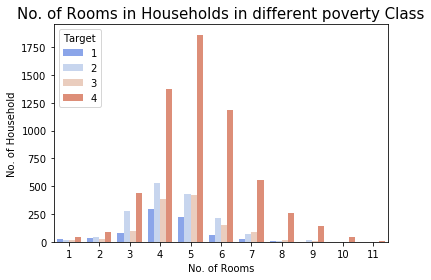

In [9]:
#train['rooms'].value_counts().plot(kind='bar', hue='Target')
sns.countplot(x="rooms", hue= "Target", data=train, palette="coolwarm")
plt.xlabel("No. of Rooms", fontsize=10)
plt.ylabel("No. of Household", fontsize=10)
plt.title("No. of Rooms in Households in different poverty Class", fontsize=15)
plt.show()

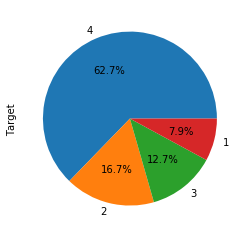

In [10]:
train['Target'].value_counts().plot(kind='pie',  autopct='%1.1f%%')
plt.show()

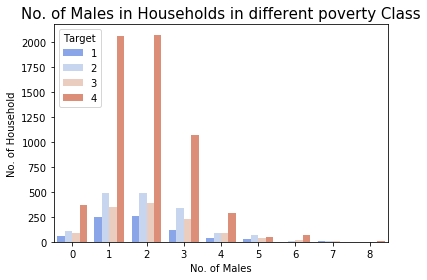

In [11]:
sns.countplot(x="r4h3", hue= "Target", data=train, palette="coolwarm")
plt.xlabel("No. of Males", fontsize=10)
plt.ylabel("No. of Household", fontsize=10)
plt.title("No. of Males in Households in different poverty Class", fontsize=15)
plt.show()

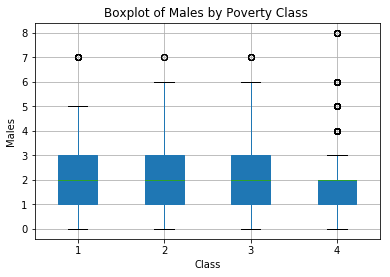

In [12]:
train.boxplot(column='r4h3', by='Target',patch_artist=True, )
plt.grid(True)
plt.xlabel("Class")
plt.ylabel("Males ")
plt.title("Boxplot of Males by Poverty Class ")
plt.suptitle("")
plt.show() 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


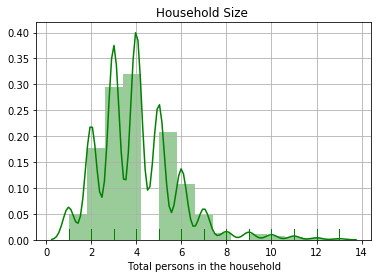

In [13]:
sns.distplot( train["r4t3"], color= 'green',  hist= True, rug= True, bins=15).grid(True)
plt.xlabel("Total persons in the household")
#plt.ylabel("Males ")
plt.title("Household Size ")
plt.suptitle("")
plt.show() 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


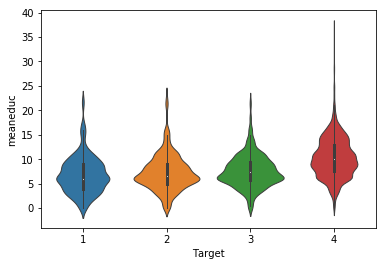

In [14]:
sns.violinplot( x=train["Target"], y=train["meaneduc"], linewidth=1)
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


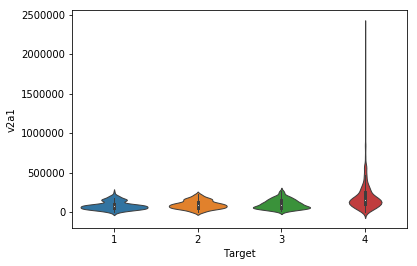

In [15]:
#Rent paid
sns.violinplot( x=train["Target"], y=train["v2a1"], linewidth=1)
plt.show()

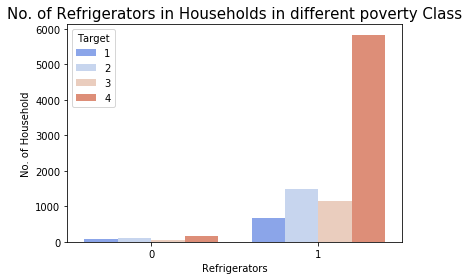

In [16]:
sns.countplot(x="refrig", hue= "Target", data=train, palette="coolwarm")
plt.xlabel("Refrigerators", fontsize=10)
plt.ylabel("No. of Household", fontsize=10)
plt.title("No. of Refrigerators in Households in different poverty Class", fontsize=15)
plt.show()

## Feature Engineering

In [18]:
# Create correlation matrix
#Subset only to the columns where parentesco1 == 1 because 
#this is the head of household, the correct label for each household.
heads = train.loc[train['parentesco1'] == 1].copy()
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['tamhog',
 'hhsize',
 'coopele',
 'female',
 'hogar_total',
 'area2',
 'SQBescolari',
 'SQBage',
 'agesq']

In [19]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total,SQBhogar_total
r4t3,1.000000,0.996884,0.929237,0.996884,0.996884,0.938911
tamhog,0.996884,1.000000,0.926667,1.000000,1.000000,0.941298
tamviv,0.929237,0.926667,1.000000,0.926667,0.926667,0.878112
hhsize,0.996884,1.000000,0.926667,1.000000,1.000000,0.941298
hogar_total,0.996884,1.000000,0.926667,1.000000,1.000000,0.941298
SQBhogar_total,0.938911,0.941298,0.878112,0.941298,0.941298,1.000000


### Interpretation
There are several variables here having to do with the size of the house:

r4t3: Total persons in the household

tamhog: size of the household

tamviv: number of persons living in the household

hhsize: household size

hogar_total: total individuals in the household

These variables are all highly correlated with one another. In fact, hhsize has a perfect correlation with tamhog and hogar_total. We will remove these two variables because the information is redundant. We can also remove r4t3 because it has a near perfect correlation with hhsize.

SQBhogar: Total individuals in the household and its square are highly correlated, hence no need to keep SQBhogar in data. 

SQBage and Age variables are highly correlated, hence no need to keep SQBage in data.

Similarly the following other 'Squared' columns are correlated to the underlying data, hence may be dropped:
SQBescolari, escolari squared
SQBedjefe, edjefe squared
SQBhogar_nin, hogar_nin squared
SQBovercrowding, overcrowding squared
SQBdependency, dependency squared
SQBmeaned, square of the mean years of education of adults (>=18) in the household
agesq, Age squared

Id and Idhogar can also be dropped.

#### The Columns are dropped before PCA so that Machine time for PCA is reduced.

### Dropping Variables

In [20]:
train.drop(['Id','idhogar','r4t3','tamhog','tamviv','hogar_total', 'SQBmeaned', 'SQBhogar_total',
            'SQBage','SQBescolari','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency',
            'SQBmeaned','agesq'], inplace = True, axis=1)
train.shape

(9557, 128)

### Filling the missing values

In [21]:
#pd.DataFrame(train.isnull().sum())

In [22]:
train.columns[train.isnull().sum()!=0]

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc'], dtype='object')

### Variables Type having Missing values
v2a1 - monthly rent

v18q1 - number of tablets

rez_esc - years behind school

meaneduc - mean education for adults

#### None of them are categorical variable.

In [23]:
#Replace the na values with the mean value of each variable
train['v2a1'] = train['v2a1'].fillna((train['v2a1'].mean()))
train['v18q1'] = train['v18q1'].fillna((train['v18q1'].mean()))
train['rez_esc'] = train['rez_esc'].fillna((train['rez_esc'].mean()))
train['meaneduc'] = train['meaneduc'].fillna((train['meaneduc'].mean()))
#Check if any na
train.columns[train.isnull().sum()!=0]

Index([], dtype='object')

### Finding Object (String) in the Data frame and converting them to Float

In [24]:
train.select_dtypes('object').head()

,dependency,edjefe,edjefa
0,no,10,no
1,8,12,no
2,8,no,11
3,yes,11,no
4,yes,11,no


In [25]:
# Converting the string to float
yes_no_map = {'no':0,'yes':1}
train['dependency'] = train['dependency'].replace(yes_no_map).astype(np.float32)
train['edjefe'] = train['edjefe'].replace(yes_no_map).astype(np.float32)
train['edjefa'] = train['edjefa'].replace(yes_no_map).astype(np.float32)

In [26]:
# Testing for String 
train.select_dtypes('object').head()

""
0
1
2
3
4


### Data Preperation

In [27]:
# Splitting data into dependent and independent variable
# X is the independent variables matrix
X = train.drop('Target', axis = 1)

# y is the dependent variable vector
y = train.Target

In [28]:
# Scaling Features
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_ss = ss.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## PCA

In [29]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=0.95)
X_PCA = pca.fit_transform(X_ss)

### Split in Train and Test

In [35]:
# split into train/test and resample the data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(X_PCA, y, random_state=1)

In [36]:
Xdt_test.shape

(2390, 83)

## Modelling

### 1. Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
anotherModel1 = RandomForestClassifier(n_estimators=100, max_features=2, oob_score=True, random_state=42)
anotherModel1 = anotherModel1.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred1 = anotherModel1.predict(Xdt_test)
ydt_pred1

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred1)
#print(con_mat_dt)
sns.heatmap(con_mat_dt,annot=True,cmap='Blues', fmt='g')
plt.title('RFM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.grid(True)
plt.show()

In [ ]:
print('    Accuracy Report: Random Forest Model\n', classification_report(ydt_test, ydt_pred1))

### 2. Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
anotherModel2 = DecisionTreeClassifier(max_depth=3, random_state=42)
anotherModel2 = anotherModel2.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred2 = anotherModel2.predict(Xdt_test)
ydt_pred2

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred2)
sns.heatmap(con_mat_dt,annot=True,cmap='Greens', fmt='g')
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: Decision Tree Model\n', classification_report(ydt_test, ydt_pred2))

### 3. Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as gbm

In [ ]:
anotherModel3 = gbm()
anotherModel3 = anotherModel3.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred3 = anotherModel3.predict(Xdt_test)
ydt_pred3

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred3)
sns.heatmap(con_mat_dt,annot=True,cmap='Reds', fmt='g')
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: Gradient Boost Model\n', classification_report(ydt_test, ydt_pred3))

### 4. K Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
anotherModel4 = KNeighborsClassifier(n_neighbors=4)
anotherModel4 = anotherModel4.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred4 = anotherModel4.predict(Xdt_test)
ydt_pred4

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred4)
sns.heatmap(con_mat_dt,annot=True,cmap='YlGnBu', fmt='g')
plt.title('K Neighbors Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: K Neighbors Model\n', classification_report(ydt_test, ydt_pred4))

### 5. Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
anotherModel5 = lgb.LGBMClassifier()
anotherModel5 = anotherModel5.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred5 = anotherModel5.predict(Xdt_test)
ydt_pred5

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred5)
sns.heatmap(con_mat_dt,annot=True,cmap='BuGn_r', fmt='g')
plt.title('Light GBM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: Light GBM Model\n', classification_report(ydt_test, ydt_pred5))

### 6. Logistic Regressioin with L1 Penalty

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
anotherModel6 = LogisticRegression(C=0.1, penalty='l1')
anotherModel6 = anotherModel6.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred6 = anotherModel6.predict(Xdt_test)
ydt_pred6

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred6)
sns.heatmap(con_mat_dt,annot=True,cmap='Purples', fmt='g')
plt.title('Logistic Regressioin with L1 Penalty Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: Logistic Regressioin with L1 Penalty Model\n', classification_report(ydt_test, ydt_pred6))

### 7. Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
anotherModel7 = ExtraTreesClassifier()
anotherModel7 = anotherModel7.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred7 = anotherModel7.predict(Xdt_test)
ydt_pred7

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred7)
sns.heatmap(con_mat_dt,annot=True,cmap='Oranges', fmt='g')
plt.title('Logistic Extra Trees Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: Extra Trees Model\n', classification_report(ydt_test, ydt_pred7))

### 8. XGB Classifier 

In [ ]:
from xgboost.sklearn import XGBClassifier as XGB

In [ ]:
anotherModel8 = XGB()
anotherModel8 = anotherModel8.fit(Xdt_train, ydt_train)

In [ ]:
ydt_pred8 = anotherModel8.predict(Xdt_test)
ydt_pred8

In [ ]:
con_mat_dt = metrics.confusion_matrix(ydt_test, ydt_pred8)
sns.heatmap(con_mat_dt,annot=True,cmap='BuGn', fmt='g')
plt.title('XGB Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print('    Accuracy Report: XGB Model\n', classification_report(ydt_test, ydt_pred8))

#### The maximum F1 value is obtained by Model 4. K Neighbors Classifier.
Applying it to the test data

In [ ]:
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV as BayesSCV

In [ ]:
bayes_tuner = BayesSCV(RandomForestClassifier(n_jobs = 2),

    #  Estimator parameters to be change/tune
    {
        'n_estimators': (100, 500),           
        'criterion': ['gini', 'entropy'],    
        'max_depth': (4, 100),               
        'max_features' : (10,64),             
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   
    },

    # 2.13
    n_iter=32,            
    cv = 3               
)

In [ ]:
#bayes_cv_tuner.fit(Xdt_train, ydt_train)

In [ ]:
test=pd.read_csv("../input/test.csv")
#test=pd.read_table("E:\\Big Data\\Costa Rica\\Data\\test.csv", engine='python', sep=',')

In [ ]:
test.drop(['Id','idhogar','r4t3','tamhog','tamviv','hogar_total', 'SQBmeaned', 'SQBhogar_total',
            'SQBage','SQBescolari','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency',
            'SQBmeaned','agesq'], inplace = True, axis=1)
test.shape

In [ ]:
test.columns[test.isnull().sum()!=0]

In [ ]:
#Replace the na values with the mean value of each variable
test['v2a1'] = test['v2a1'].fillna((test['v2a1'].mean()))
test['v18q1'] = test['v18q1'].fillna((test['v18q1'].mean()))
test['rez_esc'] = test['rez_esc'].fillna((test['rez_esc'].mean()))
test['meaneduc'] = test['meaneduc'].fillna((test['meaneduc'].mean()))
#Check if any na
test.columns[test.isnull().sum()!=0]

In [ ]:
test.select_dtypes('object').head()

In [ ]:
# Converting the string to float
yes_no_map = {'no':0,'yes':1}
test['dependency'] = test['dependency'].replace(yes_no_map).astype(np.float32)
test['edjefe'] = test['edjefe'].replace(yes_no_map).astype(np.float32)
test['edjefa'] = test['edjefa'].replace(yes_no_map).astype(np.float32)

In [ ]:
test_ss = ss.fit_transform(test)

In [ ]:
test_ss.shape

In [ ]:
pca = PCA(n_components=83)
test_PCA = pca.fit_transform(test_ss)

In [ ]:
ydt_pred41 = anotherModel4.predict(test_PCA)
ydt_pred41

In [ ]:
unique_elements, counts_elements = np.unique(ydt_pred41, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
#Saving as tab - seperated values
ydt_pred41.tofile('submit.csv', sep='\t')